**Autoencoder**

In [1]:
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
from google.colab import files
uploaded2 = files.upload()

Saving merge_an_0tm.csv to merge_an_0tm (1).csv


In [2]:
import io
import numpy as np
from numpy import array
import os
import pandas  as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import datetime
#from imblearn.over_sampling import SMOTE
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from datetime import time

import tensorflow as tf #used by tensorboard
from sklearn.metrics import classification_report #used to produce the report analysis

df = pd.read_csv('/home/giacomo/Scaricati/class/normal_behaviour/merge_0tm.csv')

cols = list(df.columns)

cols = [cols[-1]] + cols[:-1]
df = df[cols]

# drop activity (last) column
df = df.iloc[:,:-1]

# Order dataset by timestamp
#df['timestamp'] = pd.to_datetime(df['timestamp'])
#df['timestamp'].min(), df['timestamp'].max()


"""
df['morning'] = 0
df['Dates'] = pd.to_datetime(df['timestamp']).dt.date
df['Time'] = pd.to_datetime(df['timestamp']).dt.time
  
date1 = time(18, 00, 00)
df.loc[df['Time'] >= date1, 'morning'] = 1
df = df.iloc[:,:-1]
df = df.iloc[:,:-1]
"""


# drop timestamp (first) column
df = df.iloc[: , 1:]

#aggiungere colonna attività e attività buona o anomala
print(df.head())

values = df.values

   wardrobe  tv  oven  officeLight  officeDoorLock  officeDoor  officeCarp  \
0         0   0     0            0               0           0           0   
1         0   0     0            0               0           0           0   
2         0   0     0            0               0           0           0   
3         0   0     0            0               0           0           0   
4         0   0     0            0               0           0           0   

   office  mainDoorLock  mainDoor  ...  bedroomLight  bedroomDoorLock  \
0       0             1         0  ...             0                0   
1       0             1         0  ...             0                0   
2       0             1         0  ...             0                0   
3       0             1         0  ...             0                0   
4       0             1         0  ...             0                0   

   bedroomDoor  bedroomCarp  bedTableLamp  bed  bathroomLight  \
0            0            0

In [3]:
df_an = pd.read_csv('/home/giacomo/Scaricati/class/anomaly_behaviour/merge_an_0tm.csv')
#df_an = pd.read_csv(io.BytesIO(uploaded2['d1_1m_0tm.csv']))

cols = list(df_an.columns)
cols = [cols[-1]] + cols[:-1]
df_an = df_an[cols]

activity = df_an.iloc[:,-1]
cardinality = activity.shape[0]

anomaly_real = list()
for items in activity.iteritems():
  if 'ano' in items[1]:
    anomaly_real.append(items[0])

number_anomaly = len(anomaly_real)
number_ok = cardinality - number_anomaly
#for i in range(len(index)):
  #print(index[i])

# drop activity (last) column 
df_an = df_an.iloc[:,:-1]


"""
df_an['morning'] = 0
df_an['Dates'] = pd.to_datetime(df_an['timestamp']).dt.date
df_an['Time'] = pd.to_datetime(df_an['timestamp']).dt.time

date1 = time(18, 00, 00)
df_an.loc[df_an['Time'] >= date1, 'morning'] = 1
"""


# drop timestamp (first) column
df_an = df_an.iloc[: , 1:]
#df_an = df_an.iloc[:,:-1]
#df_an = df_an.iloc[:,:-1]

#print(df_an.head())

values_an = df_an.values

**Data preparation for autoencoder**

In [4]:
# split a sequence into samples
def split_sequence(sequence, n_steps):
	X = list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x = sequence[i:end_ix]
		X.append(seq_x)
	return array(X)
 
# choose a number of time steps
n_steps = 16
#n_steps = 4
#n_steps = 8

# split into samples
X = split_sequence(values, n_steps)

#print(X)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 29
X = X.reshape((X.shape[0], X.shape[1], n_features))
print(X.shape)


# split into samples
X_an = split_sequence(values_an, n_steps)

#print(X)

# reshape from [samples, timesteps] into [samples, timesteps, features]
X_an = X_an.reshape((X_an.shape[0], X_an.shape[1], n_features))
print(X_an.shape)

(295083, 16, 29)
(307643, 16, 29)


**Split data**

In [5]:
from sklearn.model_selection import train_test_split
def split_dataset(X):
    #we perform a 80:20 split of the dataset in conjunction with a randomization 
    #(shuffling the dataset is important to have a good training and a good generalization)
    X_train, X_test = train_test_split(X, test_size=0.20, random_state=42)
    return X_train, X_test

**Model building**

In [ ]:
X_train, X_test_normal = split_dataset(X)
k_size = 3
checkpoint_filepath= "/home/giacomo/Scaricati/class/models/autoencoder/auto.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='max',
    save_best_only=True)


model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Conv1D(filters=16, kernel_size=k_size, padding="same", strides=2, activation="relu"),
        #layers.Dropout(rate=0.2),
        layers.Conv1D(filters=8, kernel_size=k_size, padding="same", strides=2, activation="relu"),
        layers.Conv1DTranspose(filters=8, kernel_size=k_size, padding="same", strides=2, activation="relu"),
        #layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(filters=16, kernel_size=k_size, padding="same", strides=2, activation="relu"),
        layers.Conv1DTranspose(filters=n_features, kernel_size=k_size, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

history = model.fit(
    X_train,
    X_train,
    epochs=30,
    batch_size=128,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min"), model_checkpoint_callback],
)

#pyplot.plot(history.history["loss"], label="Training Loss")
#pyplot.plot(history.history["val_loss"], label="Validation Loss")
#pyplot.legend()
#pyplot.show()

**Detect anomalies**


How well our model can reconstruct the input data, the max MAE loss value is the worst our model has performed trying to reconstruct a sample. We will make this the threshold for anomaly detection.

In [ ]:
from keras.models import load_model
X_train, X_test_normal = split_dataset(X)

checkpoint_filepath= "/home/giacomo/Scaricati/class/models/autoencoder/auto.hdf5"

model = load_model(checkpoint_filepath)

# Get train MAE loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

#pyplot.hist(train_mae_loss, bins=50)
#pyplot.xlabel("Train MAE loss")
#pyplot.ylabel("No of samples")
#pyplot.show()

# Get reconstruction loss threshold
thres = np.max(train_mae_loss)
print("Reconstruction error threshold: ", thres)

Let's see how our model has recontructed the first sample.

(307643, 16, 29)
(59017, 16, 29)
Windows 1


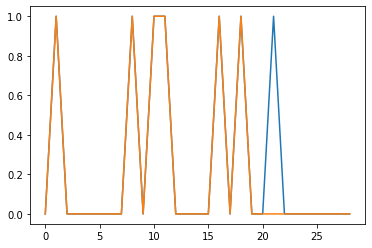

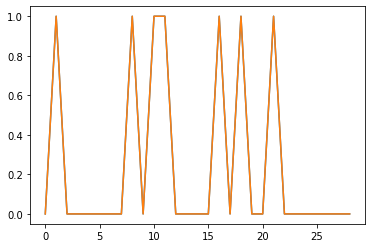

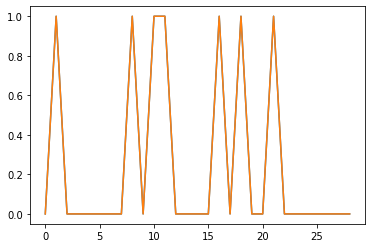

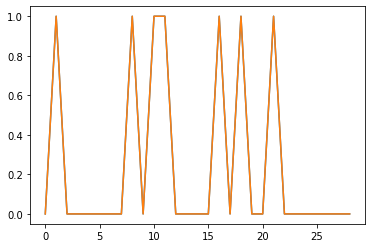

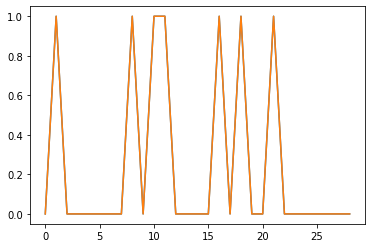

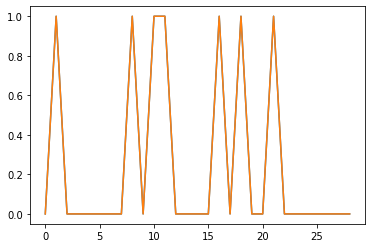

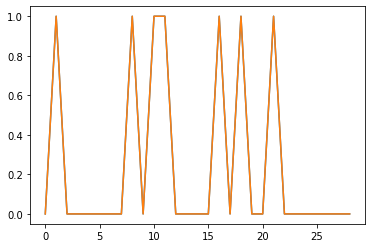

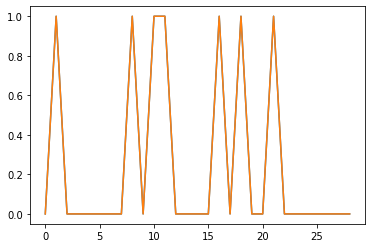

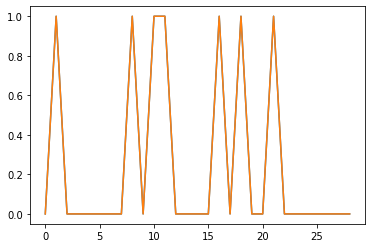

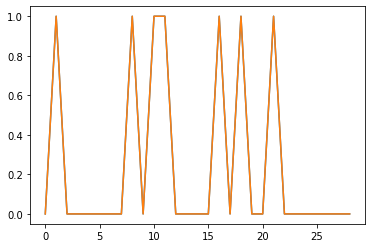

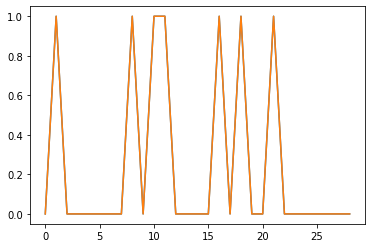

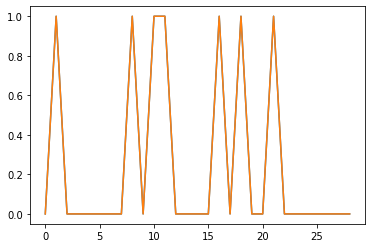

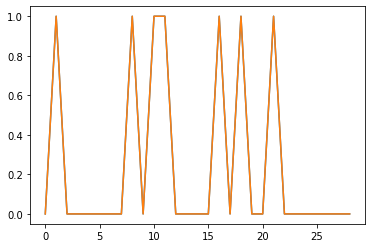

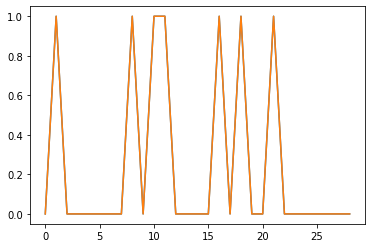

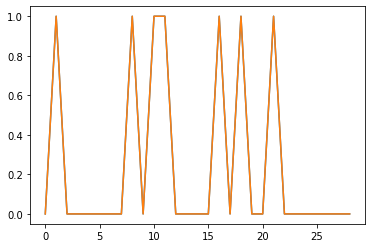

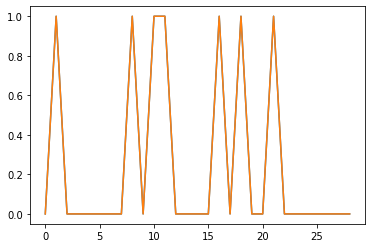

Errors: 1
AVG error: 0.0625
Windows 1


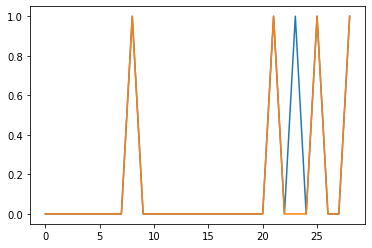

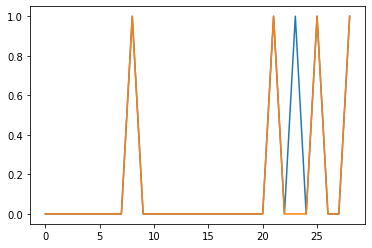

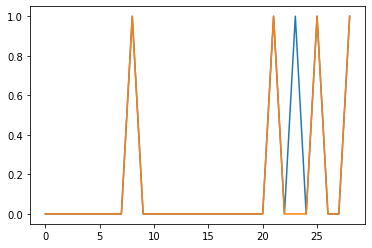

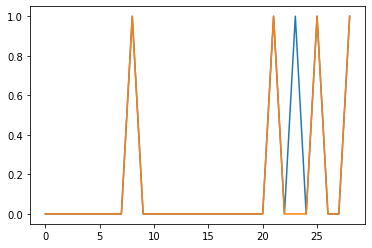

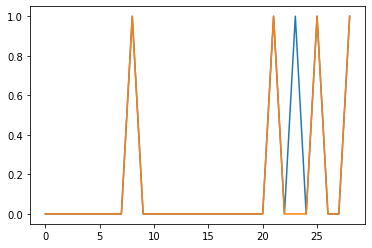

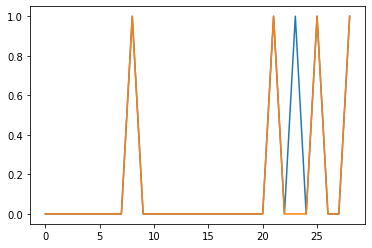

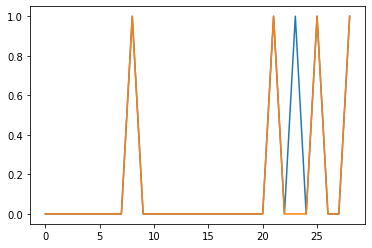

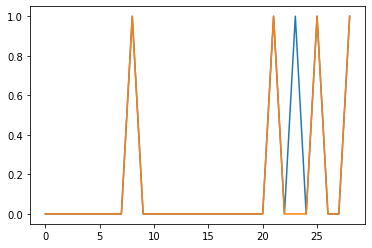

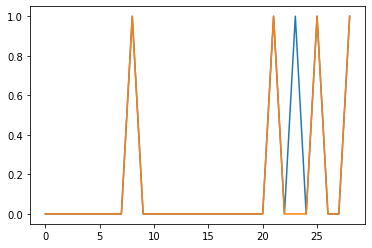

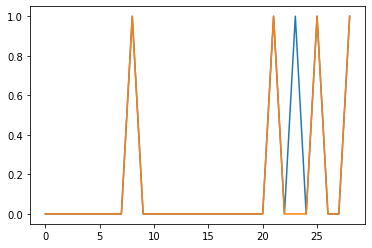

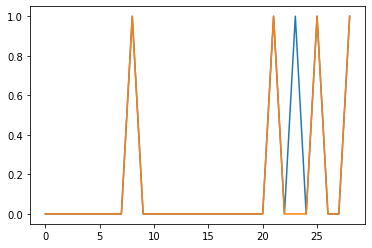

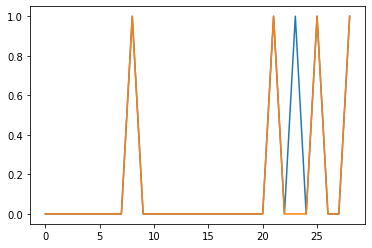

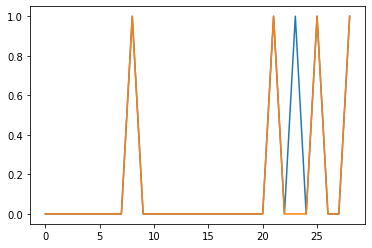

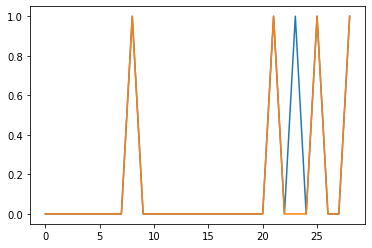

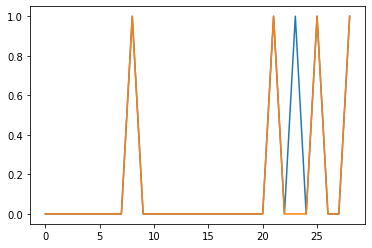

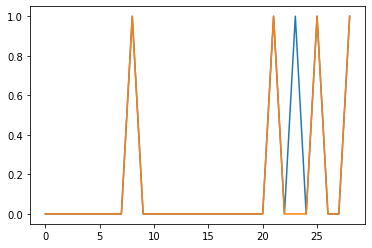

Errors: 16
AVG error: 1.0
Windows 1


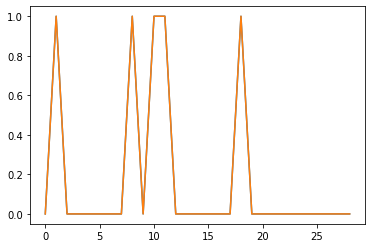

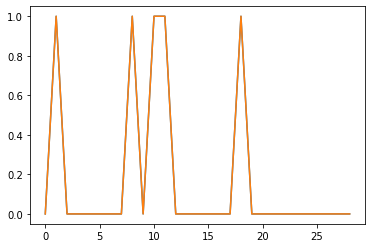

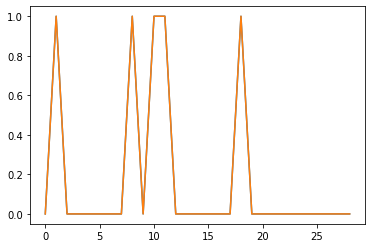

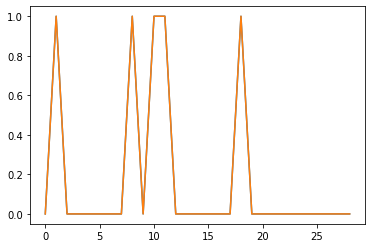

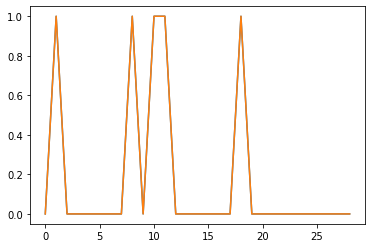

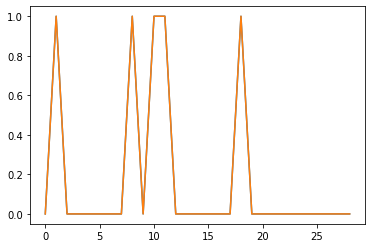

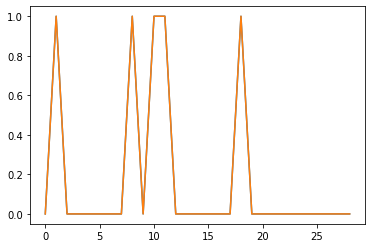

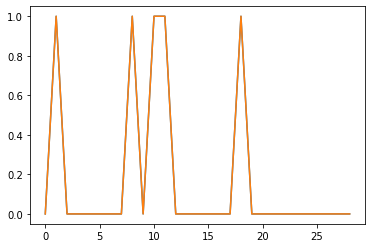

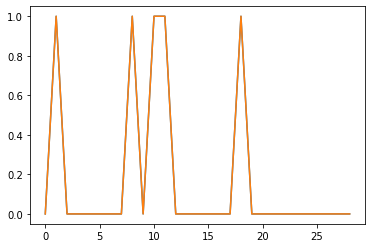

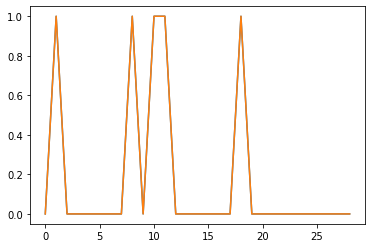

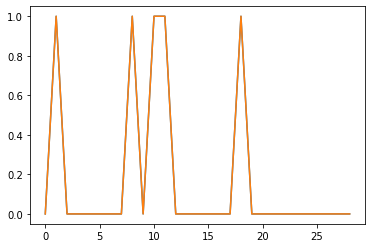

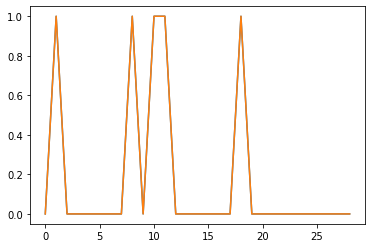

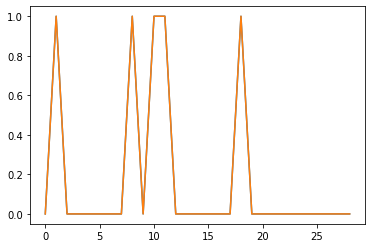

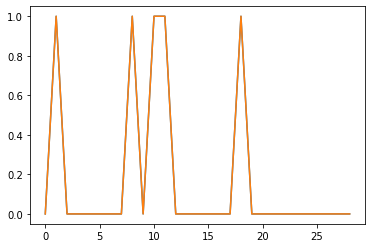

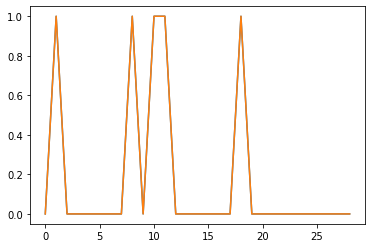

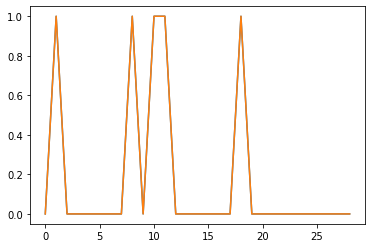

Errors: 0
AVG error: 0.0
Windows 1


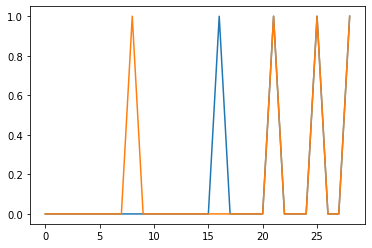

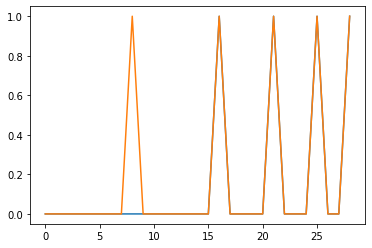

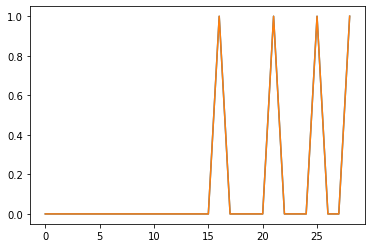

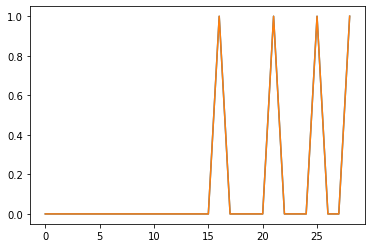

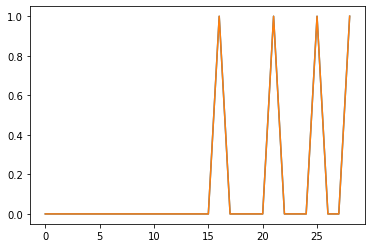

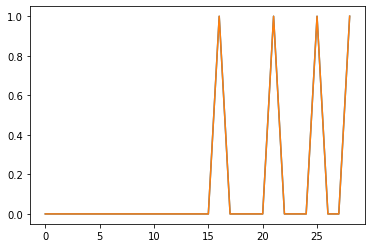

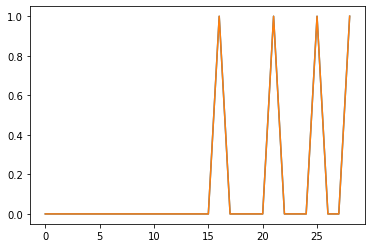

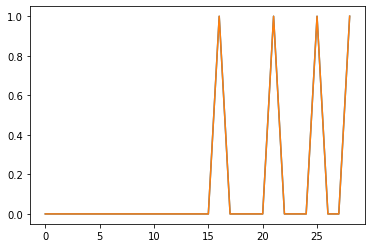

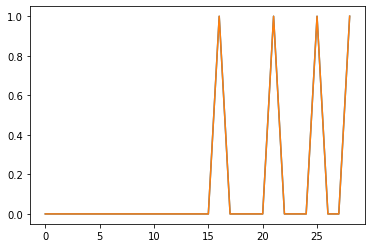

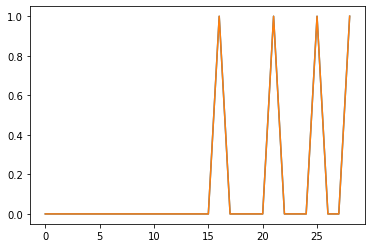

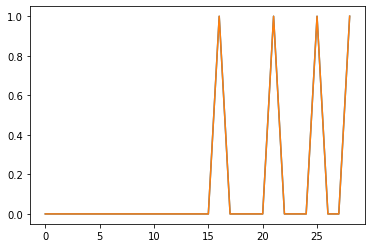

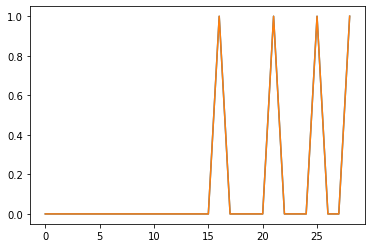

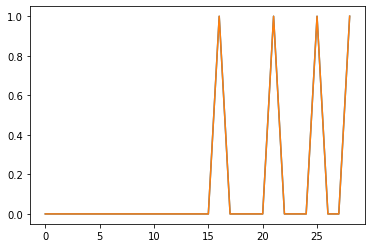

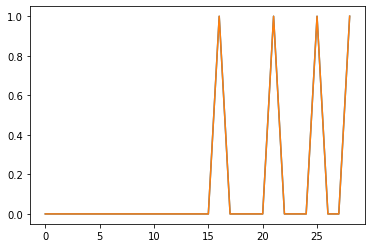

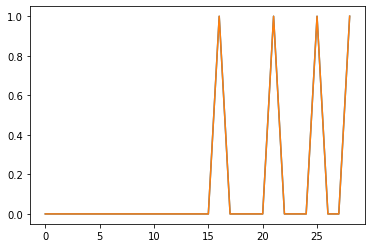

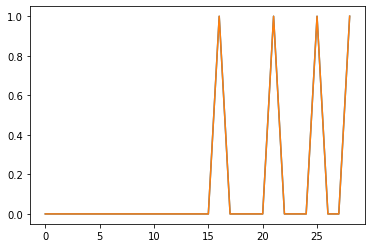

Errors: 3
AVG error: 0.1875
Windows 1


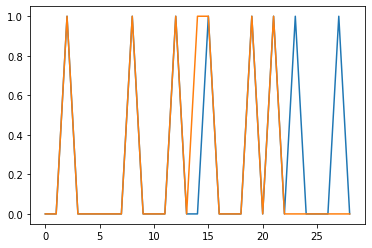

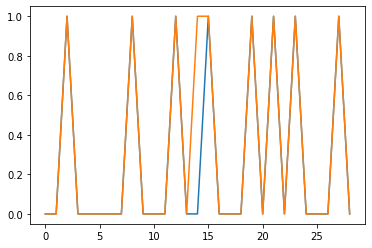

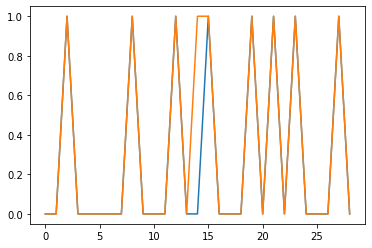

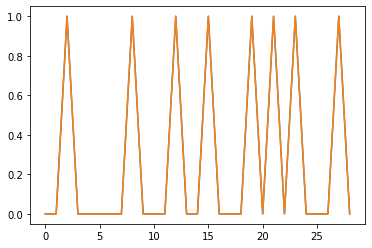

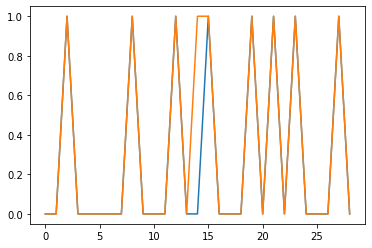

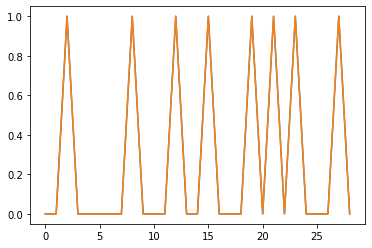

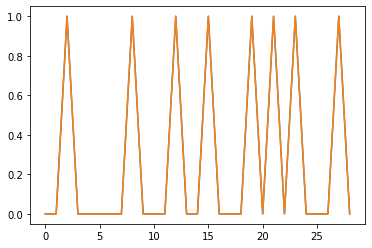

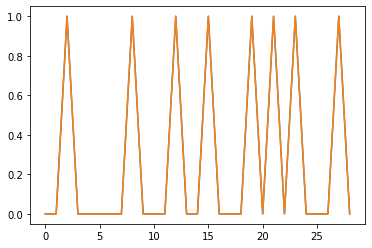

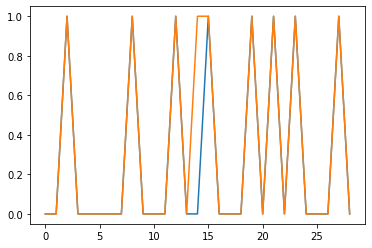

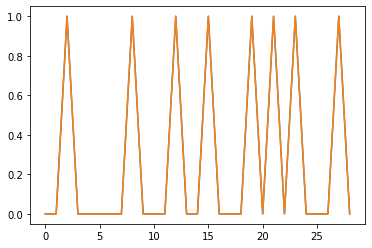

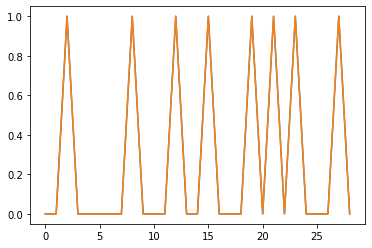

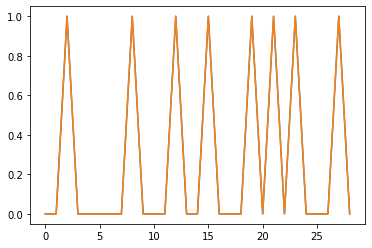

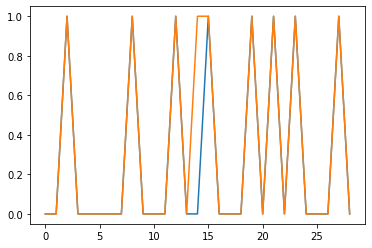

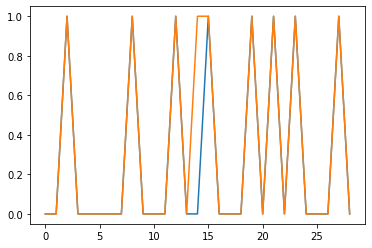

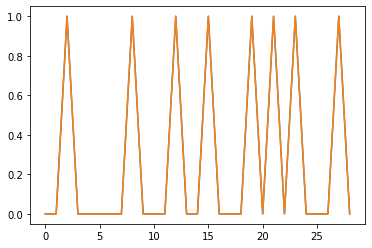

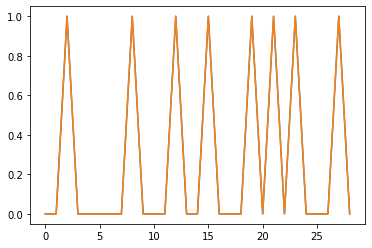

Errors: 9
AVG error: 0.5625
Windows 1


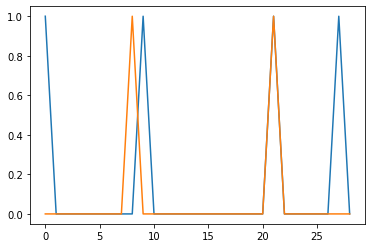

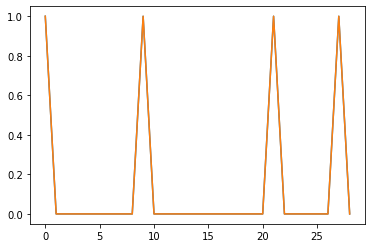

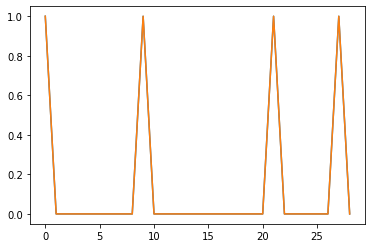

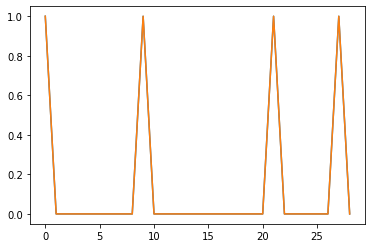

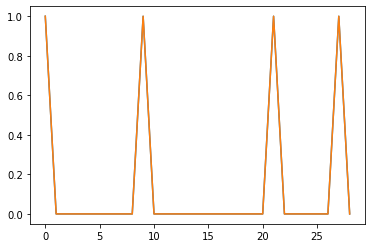

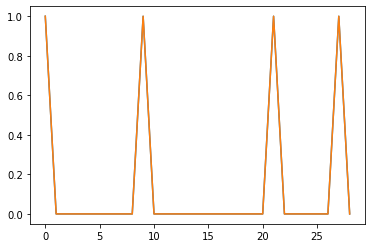

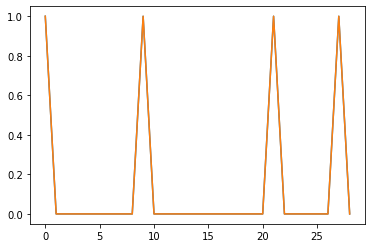

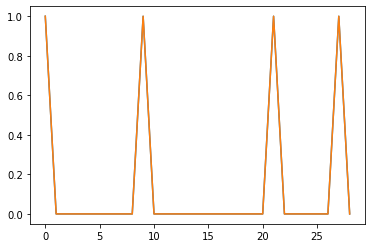

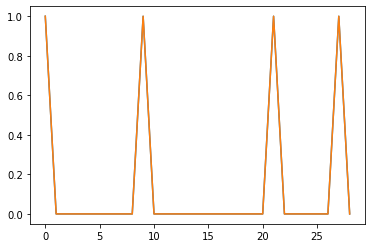

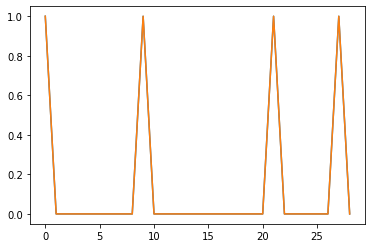

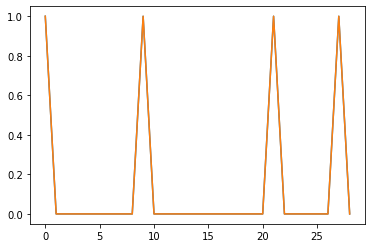

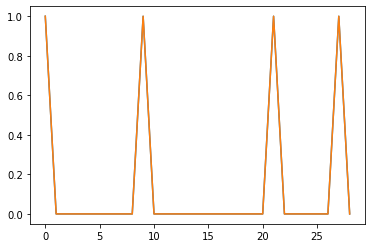

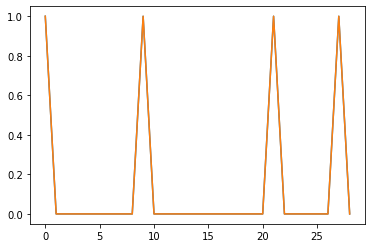

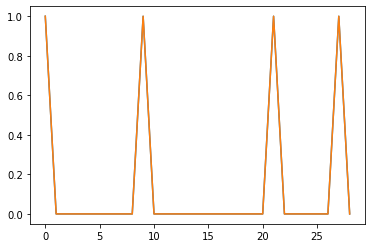

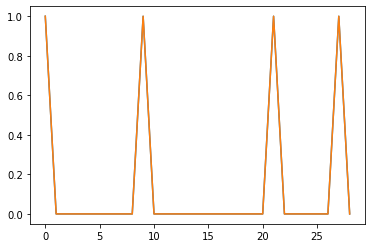

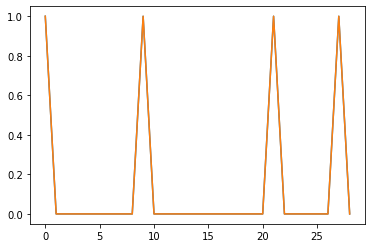

Errors: 4
AVG error: 0.25
Windows 1


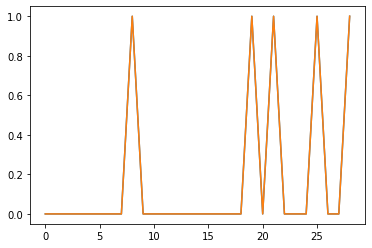

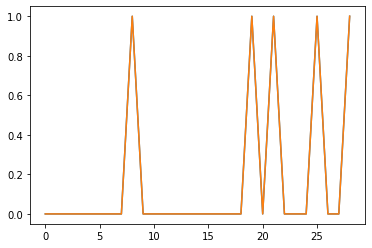

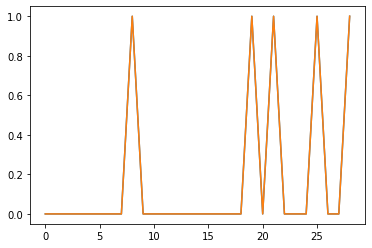

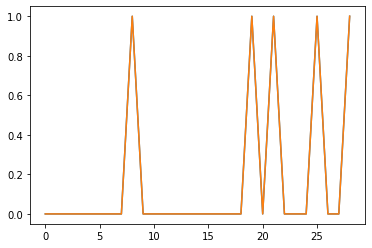

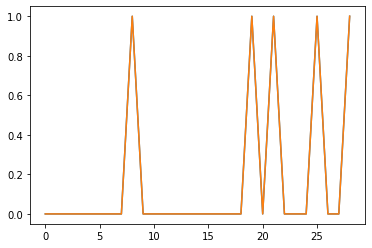

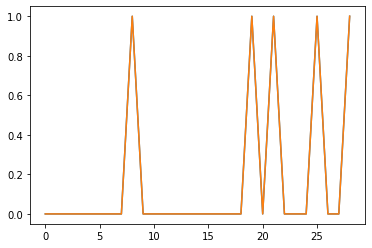

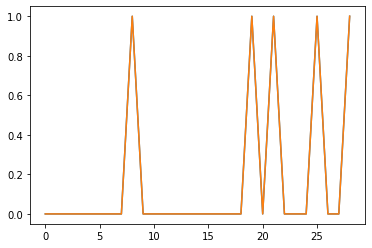

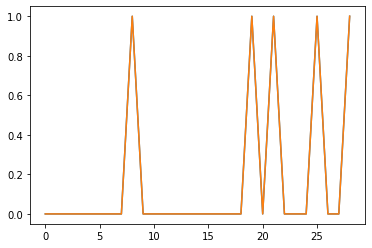

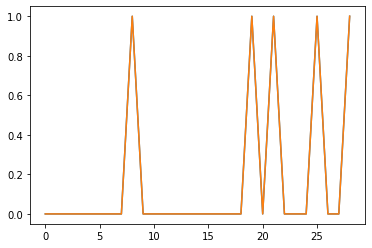

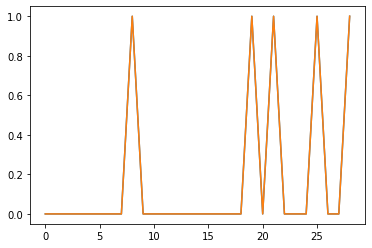

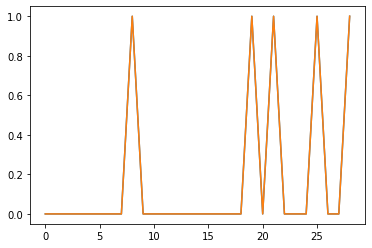

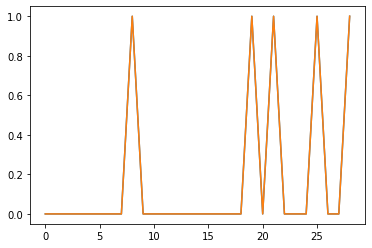

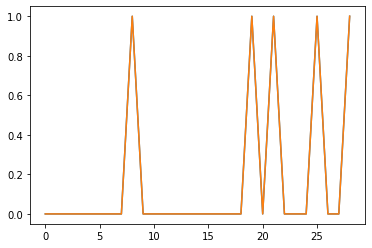

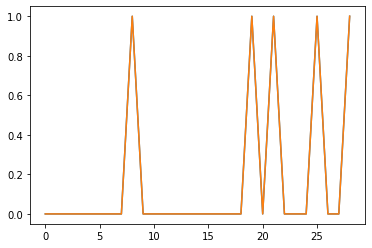

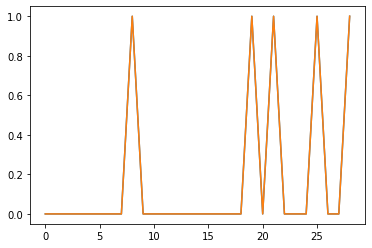

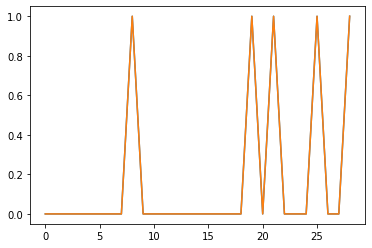

Errors: 0
AVG error: 0.0
Windows 1


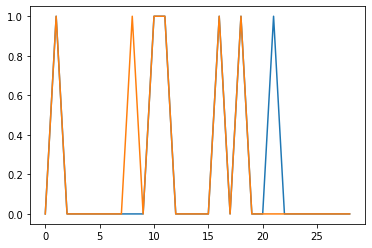

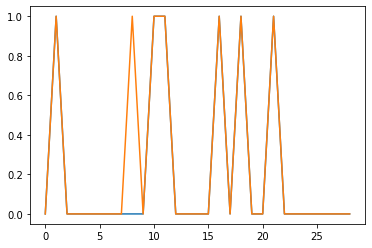

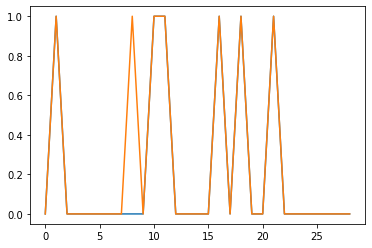

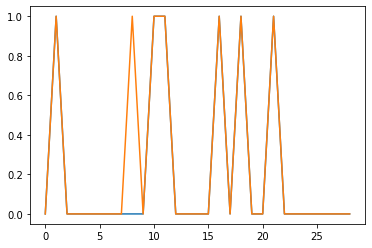

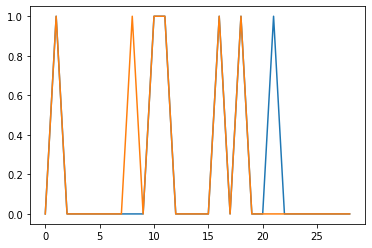

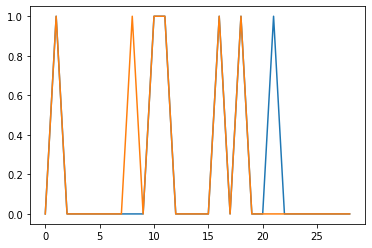

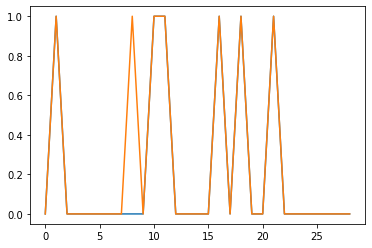

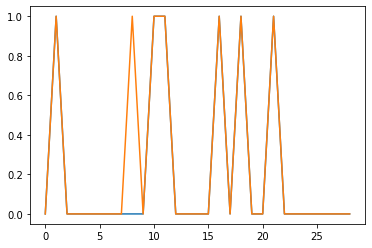

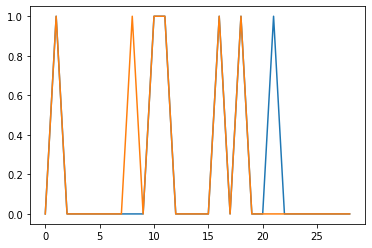

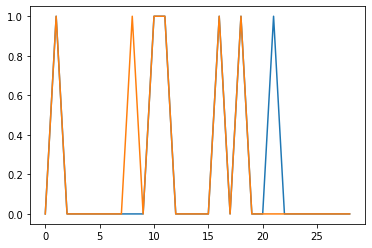

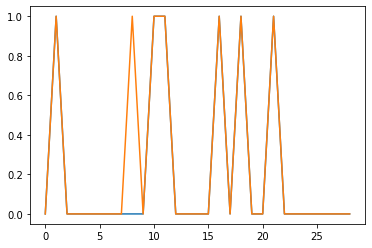

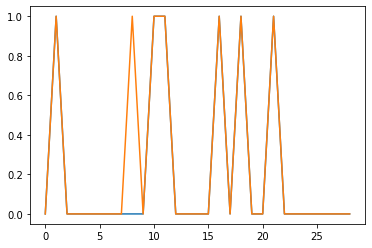

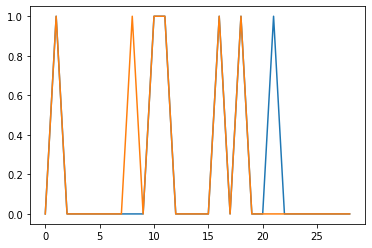

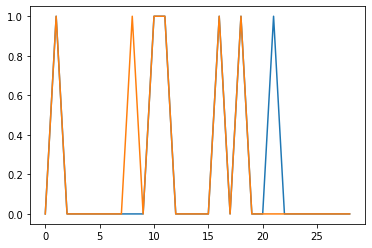

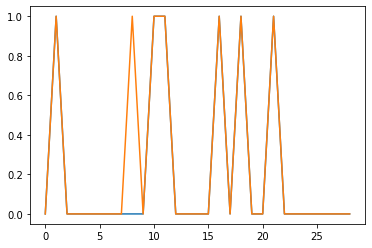

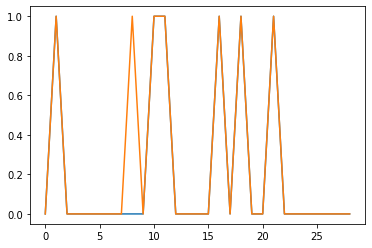

Errors: 23
AVG error: 1.4375
Windows 1


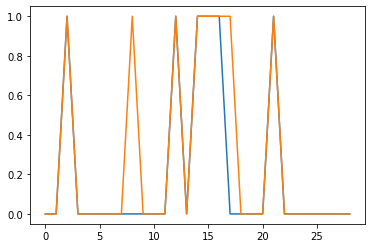

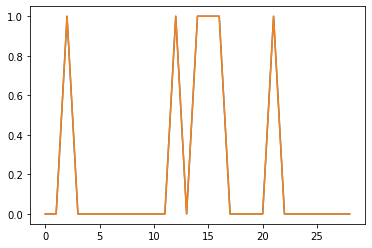

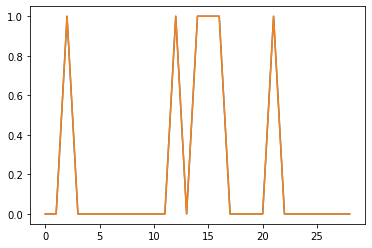

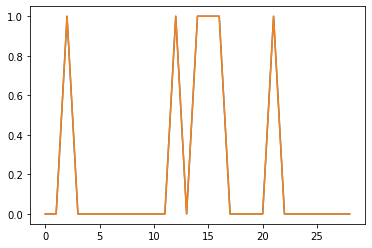

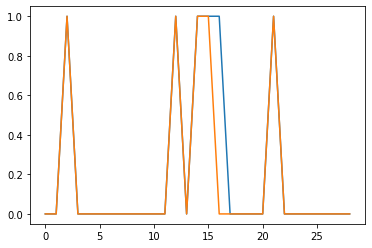

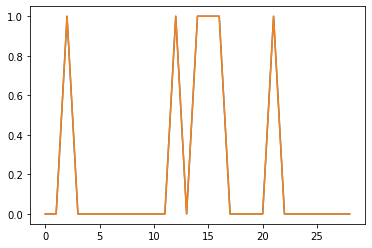

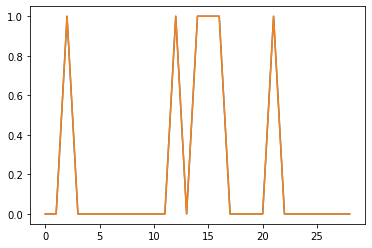

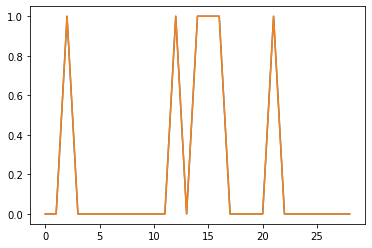

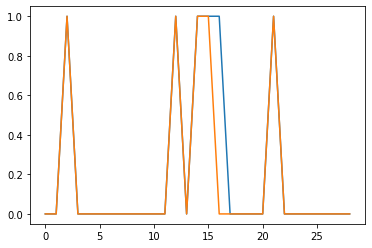

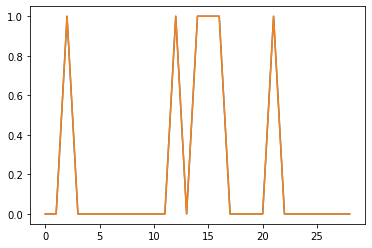

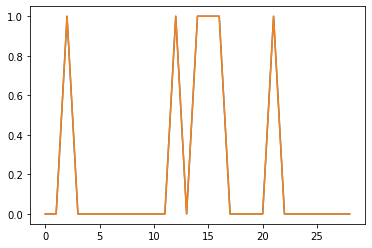

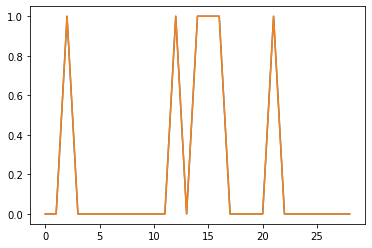

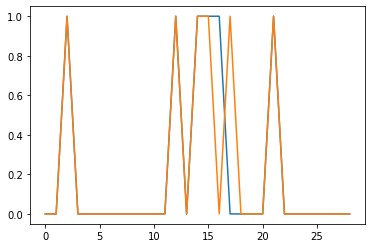

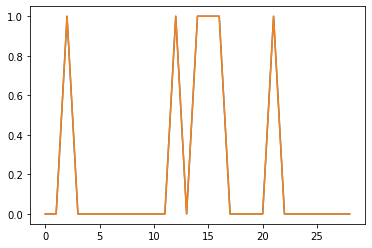

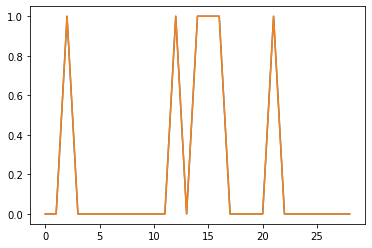

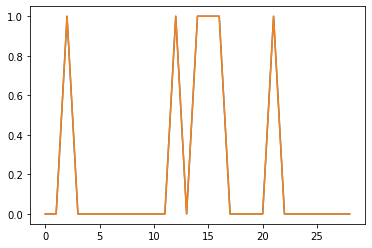

Errors: 6
AVG error: 0.375
Windows 1


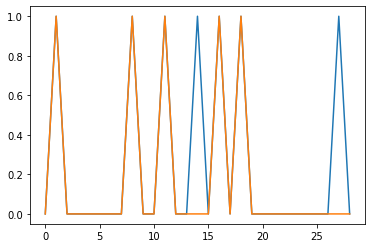

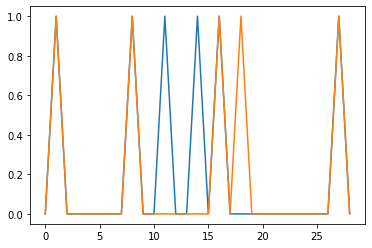

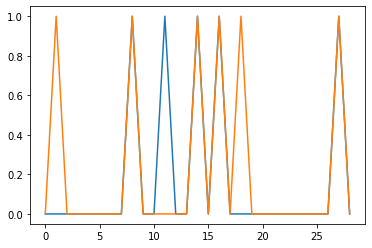

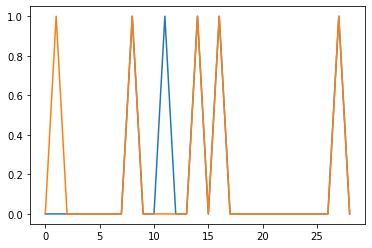

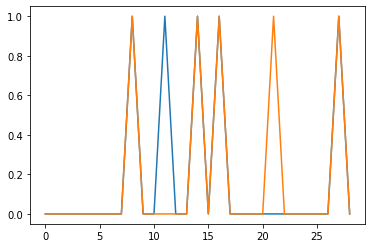

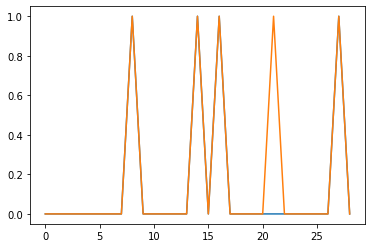

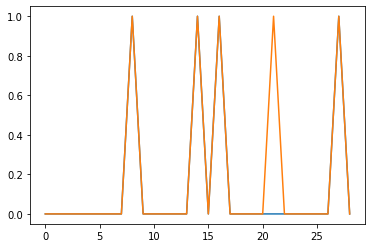

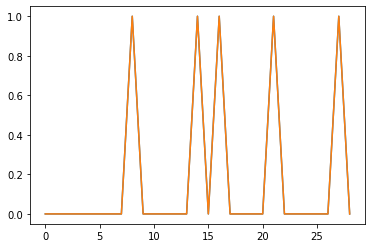

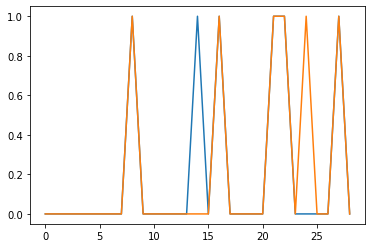

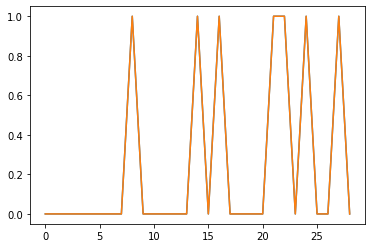

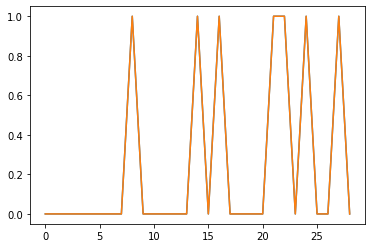

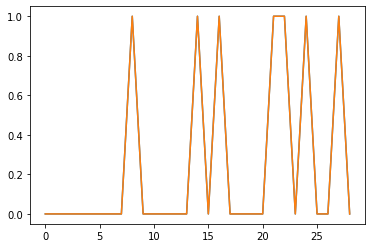

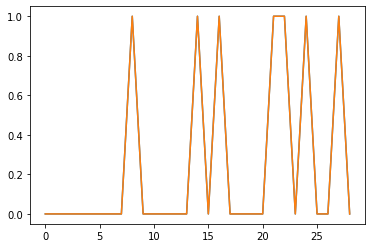

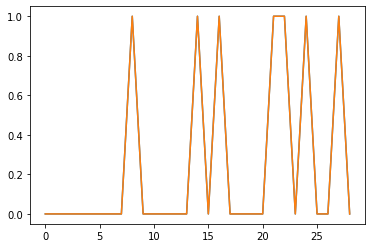

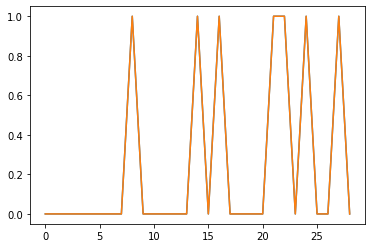

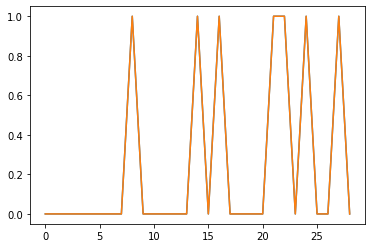

Errors: 16
AVG error: 1.0
Avg error: 0.4875
normal detected correctly: 7/10
normal detected as anomaly: 3


'\n\n\n# plot anomaly test sample and its prediction\nX_test_an_pred = model.predict(X_test_anomaly[0:100]) #predict first 100\n#plot first 10 windows\ncount_errors = 0\nnum_windows = 10\nnormal = 0\nanomaly = 0\nthreshold = 0.8\nfor i in range(0,num_windows):\n    error_window = plot_prediction(X_test_anomaly[i], X_test_an_pred[i], i, False)\n    if error_window > threshold:\n        anomaly +=1\n    else:\n        normal +=1\n    count_errors += error_window\nprint("Avg error: " + str(count_errors/num_windows))\nprint("anomaly detected correctly: " + str(anomaly) + "/" + str(num_windows))\nprint("anomaly detected as normal: " + str(normal))\n'

In [15]:
def diff(ar1, ar2):
    count = 0
    for idx,i in enumerate(ar1):
        if i != ar2[idx]:
                count +=1
    return count


def plot_prediction(X, X_pred, idx_sample, plot=False):
    # Checking how the first sequence is learnt
    idx_sample = 1
    idx_window = 1
    count_error = 0
    print("Windows " + str(idx_sample))
    for idx_sample in range(0,X.shape[0]):
        X_pred_transformed = []
        for idx_window in range(0,X.shape[1]):
            if X_pred[idx_sample][idx_window] > 0.5:
                X_pred_transformed.append(1)
            else:
                X_pred_transformed.append(0)

        #print(X[idx_sample])
        #print(np.asarray(X_pred_transformed))
        errors = diff(list(X[idx_sample]),list(np.asarray(X_pred_transformed)))
        count_error += errors
        if plot == True:
            pyplot.plot(X[idx_sample])
            pyplot.plot(X_pred_transformed)
            pyplot.show()
    print("Errors: " +  str(count_error))
    print("AVG error: " + str(count_error/X.shape[0]))
    return count_error/X.shape[0]
            
from keras.models import load_model
X_train, X_test_normal = split_dataset(X)
X_test_anomaly = X_an
print(X_test_anomaly.shape)
print(X_test_normal.shape)

checkpoint_filepath= "/home/giacomo/Scaricati/class/models/autoencoder/auto.hdf5"

model = load_model(checkpoint_filepath)
            
'''
# plot train sample and its prediction
X_train_pred = model.predict(X_train)
print(X_train_pred[0].shape)
for i in range(0,10):
    plot_prediction(X_train[i], X_train_pred[i], True)
'''

# plot normal test sample and its prediction
X_test_norm_pred = model.predict(X_test_normal[0:100]) #predict first 100
#plot first 10 windows
count_errors = 0
num_windows = 10
normal = 0
anomaly = 0
threshold = 0.8
for i in range(0,num_windows):
    error_window = plot_prediction(X_test_normal[i], X_test_norm_pred[i], i, True)
    if error_window > threshold:
        anomaly +=1
    else:
        normal +=1
    count_errors += error_window
print("Total Avg error: " + str(count_errors/num_windows))
print("Normals detected correctly: " + str(normal) + "/" + str(num_windows))
print("Normals detected as anomalies: " + str(anomaly))
'''


# plot anomaly test sample and its prediction
X_test_an_pred = model.predict(X_test_anomaly[0:100]) #predict first 100
#plot first 10 windows
count_errors = 0
num_windows = 10
normal = 0
anomaly = 0
threshold = 0.8
for i in range(0,num_windows):
    error_window = plot_prediction(X_test_anomaly[i], X_test_an_pred[i], i, False)
    if error_window > threshold:
        anomaly +=1
    else:
        normal +=1
    count_errors += error_window
print("Avg error: " + str(count_errors/num_windows))
print("anomaly detected correctly: " + str(anomaly) + "/" + str(num_windows))
print("anomaly detected as normal: " + str(normal))
'''


Prepare test data and detect anomalies (446)

In [ ]:
X_an = split_sequence(values_an, n_steps)

# Get test MAE loss.
X_an_pred = model.predict(X_an)
test_mae_loss_an = np.mean(np.abs(X_an_pred - X_an), axis=1)
#test_mae_loss_an = test_mae_loss_an.reshape((-1))

#pyplot.hist(test_mae_loss_an, bins=50)
#pyplot.xlabel("test MAE loss")
#pyplot.ylabel("No of samples")
#pyplot.show()

In [ ]:
th = thres*0.8
# Detect all the samples which are anomalies.
#anomalies = test_mae_loss_an > thres
anomalies = test_mae_loss_an > th

np.set_printoptions(threshold=np.inf)
print("Number of anomaly samples: ", np.sum(anomalies))
#print("Indices of anomaly samples: ", np.where(anomalies)[0])

Number of anomaly samples:  504


**Compute Confusion Matrix**

In [ ]:
anomaly_detected = np.where(anomalies)[0]
#remove duplicates
anomaly_detected = list(dict.fromkeys(anomaly_detected))
TP = 0
FP = 0
TN = 0
FN = 0
for ind in anomaly_detected:
  if ind in anomaly_real:
    TP = TP+1
  else:
    FP = FP+1
for ind2 in anomaly_real:
  if ind2 not in anomaly_detected:
    FN = FN+1
TN = cardinality - TP - FP - FN 
print("TP:", TP, "\nTN:", TN, "\nFP:", FP, "\nFN:", FN)

**Compute Indexes**

In [ ]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

accuracy = (TP+TN)/cardinality
accuracy = truncate(accuracy, 3)

precision = TP/(TP+FP)
precision = truncate(precision, 3)

sensitivity = TP/(TP+FN)
sensitivity = truncate(sensitivity, 3)

specificity = TN/(TN+FP)
specificity = truncate(specificity, 3)

print("Accuracy:", accuracy, "\nPrecision:", precision, "\nSensitivity:", sensitivity, "\nSpecificity:", specificity)

Accuracy: 0.983 
Precision: 0.035 
Sensitivity: 0.394 
Specificity: 0.984
